# Using HyQ with real world coordinated

In the following example we will explore HyQ's ability to handle data that is located in a real world location, a place that is uniquely identified by a coordinate reference system and coordinates.

In [1]:
import hyq
from hyq.data_retrieval import dataset_exp1

import geopandas as gpd
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import contextily as cx

spmod = hyq.GWModel()

## Preparing input information

`hyq` provides some example data that we can ue for tutorial purposes. Note that while the data is associated with real world locations, pretty much everything about it is made up for educational purposes. The hydraulic parameters or location of infrastructure is entirely fictional.

That said, let's assume we know the position of the groudwater surface in some place and would like to know how it is impacted if we start pumping water from a couple of wells.

In [2]:
rastlocs, veclocs = dataset_exp1()

H0_init_src = rasterio.open(rastlocs["H0_raster"])
H0_init_vals = H0_init_src.read()
H0_init_affine = H0_init_src.transform

pts_bbox = gpd.read_file(veclocs["pts_bbox"]["path"], layer = veclocs["pts_bbox"]["layer"])
pts_wells = gpd.read_file(veclocs["wells"]["path"], layer = veclocs["wells"]["layer"])
lns_hydroiso = gpd.read_file(veclocs["Isolines"]["path"], layer = veclocs["Isolines"]["layer"]).set_crs(epsg=25832, allow_override=True)


{'pts_bbox': {'path': PosixPath('/home/soerenw/pythonprojects/HyQ/hyq/data/sptutorial_1.gpkg'),
  'layer': 'pts_bbox'},
 'Isolines': {'path': PosixPath('/home/soerenw/pythonprojects/HyQ/hyq/data/sptutorial_1.gpkg'),
  'layer': 'Isolines'},
 'poly_bbox': {'path': PosixPath('/home/soerenw/pythonprojects/HyQ/hyq/data/sptutorial_1.gpkg'),
  'layer': 'poly_bbox'},
 'wells': {'path': PosixPath('/home/soerenw/pythonprojects/HyQ/hyq/data/sptutorial_1.gpkg'),
  'layer': 'wells'}}

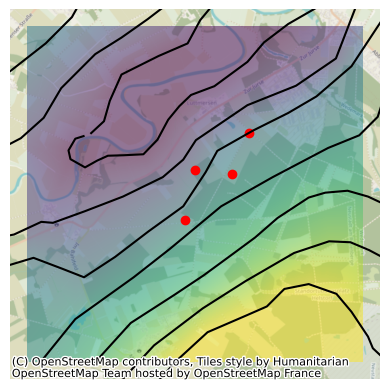

In [3]:
fig, ax = plt.subplots()
ax = pts_bbox.plot(color='none', ax=ax)
cx.add_basemap(ax, crs=H0_init_src.crs)
ax = show(H0_init_src, ax=ax, alpha = 0.5)
ax = lns_hydroiso.plot(ax=ax, color = "black")
ax = pts_wells.plot(ax=ax, color = "red")
ax.set_axis_off()


In [4]:
spmod.set_grid(
    x_min = H0_init_src.transform[2], # left border easting
    y_max = H0_init_src.transform[5], # upper border northing
    len_x= 4000, # width of the model space [m] 
    len_y = 4000, # height of the model space [m]
    res_x=50, # width of a grid cell [m]
    res_y=50, # height of a grid cell [m]
    crs = "EPSG:25832" # spatial coordinate reference system
)

In [5]:
for f in pts_wells.itertuples():
    spmod.add_wells(
        hyq.well(ID = f.Name, x = f.Easting, y = f.Northing, Q = f.Q_m3_s/1000)
    )

In [8]:
spmod.set_aquiferparams(
    H0 = 10, # Initial head above aquitard (uniform over the entire grid (yes, a simplification, obviously)
    T = 0.02, # Transmissivity [m²/s]
    S = 0.05, # Storativity [dimensionless]
    M = 10, # Thickness of the aquifer
    confined=False # whether this is an confined aquifer (it's not, in this example)
)

# Tell the model at what times we wish to inspect the heads
spmod.set_timesteps([60*60*24*10, 60*60*24*100]) # Points in time as seconds after pumping started
spmod.run()
resrast = spmod.H[0]

IndexError: list index out of range

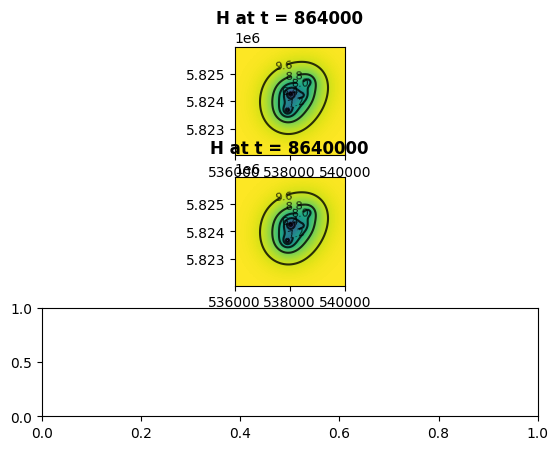

In [9]:
spmod.plot()